In [77]:
import pandas as pd
import numpy as np
from gurobipy import *
from datetime import datetime
import matplotlib.pyplot as plt

GHP = pd.read_csv("/Users/phil/Desktop/Smart_Grid_Applications_Python/3_Uebung/GHP.csv", sep = ";",decimal=',')
w_forecast = pd.read_csv("/Users/phil/Desktop/Smart_Grid_Applications_Python/3_Uebung/Wind_Forecast.csv", header=3, sep=",", decimal=".")
w_real = pd.read_csv("/Users/phil/Desktop/Smart_Grid_Applications_Python/3_Uebung/Wind_real.csv", header=3, delimiter=",", decimal=".")
intraday = pd.read_csv("/Users/phil/Desktop/Smart_Grid_Applications_Python/3_Uebung/Preise_Intraday.csv", header=1, delimiter=",", decimal=".")

In [78]:
GHP.drop(GHP.columns[3:19], axis=1, inplace=True)
GHP["time"] = GHP["Datum"] + " " + GHP["Uhrzeit"]
GHP["time"] = pd.to_datetime(GHP["time"], format='%d.%m.%Y %H:%M')
GHP.rename(columns={'Deutschland/Luxemburg[€/MWh]': 'DeutschlandLuxemburg'}, inplace=True)
del GHP["Datum"]
del GHP["Uhrzeit"]
GHP = GHP.loc[(GHP.time >= '2019-09-01 00:00:00') & (GHP.time <= '2019-09-30 23:00:00')] 
GHP

,DeutschlandLuxemburg,time
5831,27.20,2019-09-01 00:00:00
5832,26.70,2019-09-01 01:00:00
5833,26.47,2019-09-01 02:00:00
5834,25.92,2019-09-01 03:00:00
5835,25.29,2019-09-01 04:00:00
...,...,...
6546,64.37,2019-09-30 19:00:00
6547,57.34,2019-09-30 20:00:00
6548,49.27,2019-09-30 21:00:00
6549,44.58,2019-09-30 22:00:00


In [79]:
w_forecast.drop(w_forecast.columns[3:14], axis = 1, inplace = True)
w_forecast["time"] = pd.to_datetime(w_forecast["time"], format='%d.%m.%Y %H:%M') 
del w_forecast["local_time"]
w_forecast.dropna(inplace=True)
w_forecast


,time,electricity
0,2019-09-01 00:00:00,2.535175
1,2019-09-01 01:00:00,2.335636
2,2019-09-01 02:00:00,3.535083
3,2019-09-01 03:00:00,2.693114
4,2019-09-01 04:00:00,2.203940
...,...,...
715,2019-09-30 19:00:00,1.876225
716,2019-09-30 20:00:00,2.418040
717,2019-09-30 21:00:00,2.561387
718,2019-09-30 22:00:00,2.109005


In [80]:
def get_results_in_df(variableNames, n_timesteps,model_name):
   

    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)])
    
    for n in variableNames: 
        for t in range(n_timesteps): 
            VarName = n + f"[{t}]" 
            try:
                results_df.loc[t][n] = model_name.getVarByName(VarName).x 
            except:
                pass
    return results_df

In [81]:
def model(w_forecast_day,Strompreis,n_timesteps):

    m  = Model("Forecast_Wind")
    
    #Definitionen
    storage = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub = 15, name = "Speicher") # lb = lower bound; ub = upper bound
    laden = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb =-5, ub = 5, name = "Laden") # lb = lower bound; ub = upper bound
    verkauf = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, name = "Einspeisung") # lb = lower bound; ub = upper bound
    
    #Zielfunktion
    
    m.setObjective(( quicksum(Strompreis[t]/1000 * verkauf[t]  for t in range(n_timesteps) ) ), GRB.MAXIMIZE) #quicksum(... for t in range(start, end))  bildet die Summe über alle variablen von t=0 bis t=23
    
    
    #Bedingungen
    m.addConstrs( ((storage[t] == storage[t-1] + laden[t-1] )  for t in range(1,n_timesteps) ), "Speicher2") # Diese Nebenbedingung gilt für alle Zeitschritte
    m.addConstrs( ((verkauf[t] == w_forecast_day[t] - laden[t]) for t in range(n_timesteps) ), "Verkauf") # Diese Nebenbedingung funktioniert nicht im ersten und letzten Zeitschritt, da dann ein Index-Error aufkommen würde (es gibt keinen zeitschritt -1 und 24). Daher starten wir die range bei 1 und iterieren nur bis 22.
    m.addConstrs(-laden[t] <= storage[t] for t in range(1,n_timesteps)) 
    
    #Start- und Endbedingungen
    m.addConstr(storage[0] == 0)
    #m.addConstr(laden[0] >= 0)
    

    m.optimize()
    
    newTable = ["Laden","Einspeisung","Speicher"]
    timesteps = n_timesteps
    w_forecast_results = get_results_in_df(newTable, timesteps, m)
    return w_forecast_results


In [82]:
newTable = ["Laden","Einspeisung","Speicher"]
table = pd.DataFrame(columns= newTable)
GHP.reset_index(inplace = True)


In [83]:


for i in range(1,31):
    w_forecast_day = w_forecast["electricity"].loc[w_forecast["time"].dt.day == i].to_list()
    Strompreis = GHP["DeutschlandLuxemburg"].loc[GHP["time"].dt.day == i].to_list()
    n_timesteps = len(w_forecast_day)
    #print(w_forecast_day)
    #print(Strompreis)
    #print(n_timesteps)
    table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
   
    
table.reset_index(inplace = True)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0xc1cf50b6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [9e-01, 4e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.02s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5383314e+00   3.639536e+02   0.000000e+00      0s
      12    1.5291291e+00   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.529129078e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processo

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0xcab73571
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [2e-01, 3e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.02s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8855593e+00   1.881913e+02   0.000000e+00      0s
      12    1.2195967e+00   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.05 seconds (0.00 work units)
Optimal objective  1.219596719e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processo

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9194840e+00   3.752294e+02   0.000000e+00      0s
       9    1.8112958e+00   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.05 seconds (0.00 work units)
Optimal objective  1.811295829e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0x8b663066
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 4e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [6e-02, 2e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.01s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0506260e+00   3.796803e+02   0.000000e+00 

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be re

  RHS range        [1e-02, 2e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.04s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7797332e+00   3.842489e+02   0.000000e+00      0s
       9    1.2280342e+00   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.06 seconds (0.00 work units)
Optimal objective  1.228034205e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0xa7ba811a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [9e-02, 1e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.02s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective   

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be re


CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0x89595021
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [3e-01, 2e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.02s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9032434e+00   3.046768e+02   0.000000e+00      0s
      10    9.7934061e-01   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.03 seconds (0.00 work units)
Optimal objective  9.793406099e-01
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 c

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be re

Solved in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.416150444e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0xd84e6331
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [1e+00, 4e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.01s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8909160e+00   3.666582e+02   0.000000e+00      0s
      10    2.5140038e+00   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.514003782e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU mode

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0x6998aab7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [3e-01, 4e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.02s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2204346e+00   3.635231e+02   0.000000e+00      0s
       9    1.8425764e+00   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.842576365e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processor

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


  Bounds range     [5e+00, 2e+01]
  RHS range        [6e-01, 5e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.03s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7277752e+00   3.623911e+02   0.000000e+00      0s
      12    2.3161232e+00   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.05 seconds (0.00 work units)
Optimal objective  2.316123188e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0xdc580d00
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 7e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [5e-01, 5e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.03s
Presolved: 45 rows, 46 columns, 112 

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0x5ac58749
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 5e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [1e+00, 4e+00]
Presolve removed 26 rows and 26 columns
Presolve time: 0.01s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3456514e+00   3.642159e+02   0.000000e+00      0s
      16    3.1271033e+00   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.127103311e+00
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processo

/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 71 rows, 72 columns and 164 nonzeros
Model fingerprint: 0x54dae391
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 6e-02]
  Bounds range     [5e+00, 2e+01]
  RHS range        [2e+00, 1e+01]
Presolve removed 26 rows and 26 columns
Presolve time: 0.02s
Presolved: 45 rows, 46 columns, 112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1079382e+00   3.475000e+02   0.000000e+00      0s
      11    3.1798733e+00   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.179873305e+00


/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))
/var/folders/25/bg4kk_cj0cg03qf79n8cx9qm0000gn/T/ipykernel_1958/3137722346.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table= table.append(model(w_forecast_day, Strompreis, n_timesteps))


In [84]:
table

,index,Laden,Einspeisung,Speicher
0,0,0.0,2.535175,0.0
1,1,2.335636,0.0,0.0
2,2,3.535083,0.0,2.335636
3,3,2.693114,0.0,5.870719
4,4,2.20394,0.0,8.563833
...,...,...,...,...
715,19,-5.0,6.876225,10.0
716,20,-5.0,7.41804,5.0
717,21,0.0,2.561387,0.0
718,22,0.0,2.109005,0.0


In [85]:
#Teil (ii)

In [86]:
#Aufbereitung w_real
w_real.drop(w_real.columns[3:14], axis = 1, inplace = True)
w_real["time"] = pd.to_datetime(w_real["time"], format='%d.%m.%Y %H:%M')
w_real = w_real.loc[(w_real.time >= '2019-09-01 00:00:00') & (w_real.time <= '2019-09-30 23:00:00')]
del w_real["local_time"]
w_real

,time,electricity
0,2019-09-01 00:00:00,3.000
1,2019-09-01 01:00:00,2.988
2,2019-09-01 02:00:00,2.855
3,2019-09-01 03:00:00,2.666
4,2019-09-01 04:00:00,2.453
...,...,...
715,2019-09-30 19:00:00,1.864
716,2019-09-30 20:00:00,2.010
717,2019-09-30 21:00:00,2.360
718,2019-09-30 22:00:00,2.785


In [87]:
intraday.dropna(inplace=True) #Löscht alle Zeilen mit NaN
intraday["Delivery day"] = intraday["Delivery day"].values[::-1] #Verdrehung der Reihenfolge der Zeilen
intraday["Hour from"] = intraday["Hour from"].values[::-1]
intraday["Hour to"] = intraday["Hour to"].values[::-1]
intraday["ID3-Price"] = intraday["ID3-Price"].values[::-1]
intraday["Preis_pro_kWh"] = intraday["ID3-Price"] / 1000

intraday


,Delivery day,Hour from,Hour to,ID3-Price,Preis_pro_kWh
0,01.09.2019,1.0,1.0,20.55,0.02055
1,01.09.2019,2.0,2.0,21.25,0.02125
2,01.09.2019,3.0,3.0,20.52,0.02052
3,01.09.2019,4.0,4.0,22.36,0.02236
4,01.09.2019,5.0,5.0,25.67,0.02567
...,...,...,...,...,...
715,30.09.2019,20.0,20.0,56.38,0.05638
716,30.09.2019,21.0,21.0,47.60,0.04760
717,30.09.2019,22.0,22.0,42.44,0.04244
718,30.09.2019,23.0,23.0,37.87,0.03787


In [88]:
wind_forecast = np.array(w_forecast.electricity)
wind_real = np.array(w_real.electricity)
einspeisung = np.array(table.Einspeisung)
price_dayahead= np.array(GHP.DeutschlandLuxemburg/1000)
price_intraday = np.array(intraday.Preis_pro_kWh)


differenz_total = []
umsatz_intraday = []
umsatz_dayahead = []
t=0


while t <= len(wind_real)-1:
    differenz = wind_real[t] - wind_forecast[t] #Wenn differenz = pos, dann verkaufen intraday; sonst kaufen
    differenz_total.append(differenz)
    umsatz_intraday1 = price_intraday[t]*differenz_total[t]
    umsatz_intraday.append(umsatz_intraday1)
    umsatz_dayahead1 = einspeisung[t]*price_dayahead[t]
    umsatz_dayahead.append(umsatz_dayahead1)
    t = t+1
       
table.insert(loc=len(table.columns), column='wind_forecast [kW]', value=wind_forecast)
table.insert(loc=len(table.columns), column='wind_real [kW]', value=wind_real)
table.insert(loc=len(table.columns), column='Differenz Forecast und Real [kW]', value=differenz_total)
table.insert(loc=len(table.columns), column='price_intraday [€/kWh]', value=price_intraday)
table.insert(loc=len(table.columns), column='Umsatz Intraday [€]', value=umsatz_intraday)
table.insert(loc=len(table.columns), column='Umsatz Dayahead [€]', value=umsatz_dayahead)




table



,index,Laden,Einspeisung,Speicher,wind_forecast [kW],wind_real [kW],Differenz Forecast und Real [kW],price_intraday [€/kWh],Umsatz Intraday [€],Umsatz Dayahead [€]
0,0,0.0,2.535175,0.0,2.535175,3.000,0.464825,0.02055,0.009552,0.068957
1,1,2.335636,0.0,0.0,2.335636,2.988,0.652364,0.02125,0.013863,0.000000
2,2,3.535083,0.0,2.335636,3.535083,2.855,-0.680083,0.02052,-0.013955,0.000000
3,3,2.693114,0.0,5.870719,2.693114,2.666,-0.027114,0.02236,-0.000606,0.000000
4,4,2.20394,0.0,8.563833,2.203940,2.453,0.249060,0.02567,0.006393,0.000000
...,...,...,...,...,...,...,...,...,...,...
715,19,-5.0,6.876225,10.0,1.876225,1.864,-0.012225,0.05638,-0.000689,0.442623
716,20,-5.0,7.41804,5.0,2.418040,2.010,-0.408040,0.04760,-0.019423,0.425350
717,21,0.0,2.561387,0.0,2.561387,2.360,-0.201387,0.04244,-0.008547,0.126200
718,22,0.0,2.109005,0.0,2.109005,2.785,0.675995,0.03787,0.025600,0.094019


In [ ]:
#Teil (iii)

In [19]:
speicherstand = np.array(table.Speicher)
speichereinsatz = np.array(table.Laden)


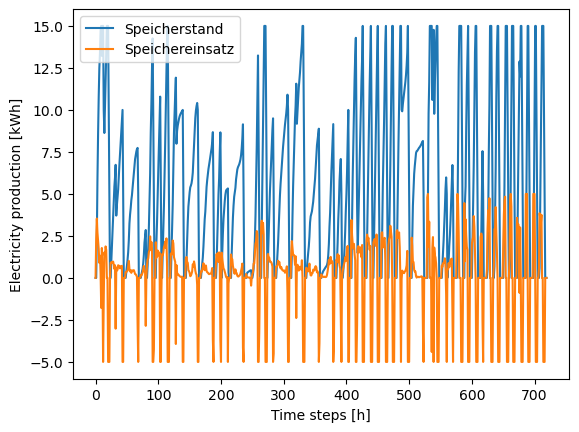

In [27]:
#Beschriftung x- und y-Achse
plt.xlabel("Time steps [h]")
plt.ylabel("Electricity production [kWh]")


#Ausgabe der Daten und Anzeige der Legende
plt.plot(speicherstand, label = "Speicherstand")
plt.plot(speichereinsatz, label = "Speichereinsatz")
plt.legend(loc="upper left")
plt.show()